<a href="https://colab.research.google.com/github/Karishma-Kuria/DL-Assignment4/blob/main/DL_Assignment4_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **b) Various experiments with weights and biases of hyperparameters in weights and biases of various optimizers, layer depth width, learning rate etc both in keras and pytorch**

Ref: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb

### **Introduction to Hyperparameter Sweeps using W&B**

Using Hyperparameter sweeps provides a better way to pick the most accurate model.  This is done by seraching through the various combination of Hyperparameter values which results in getting the best optimal values.

In this colab we will use Weights and Biases to run sophisticated hyperparameter sweeps in 3 easy steps.

**Sweeps: An Overview**

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

**Define the sweep**: we do this by creating a dictionary or a YAML file that specifies the parameters to search through, the search strategy, the optimization metric et all.

**Initialize the sweep**: with one line of code we initialize the sweep and pass in the dictionary of sweep configurations: sweep_id = wandb.sweep(sweep_config)

**Run the sweep agent**: also accomplished with one line of code, we call wandb.agent() and pass the sweep_id to run, along with a function that defines your model architecture and trains it: wandb.agent(sweep_id, function=train)

### **Setup**

In [ ]:
# install
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-03-31 05:46:17--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-03-31 05:46:17--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [           <=>      ]  33.20M  14.9MB/s    in 2.2s    

2022-03-31 05:46:20 (14.9 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [ ]:
import wandb
wandb.login()

True

## **Step 1️⃣. Define the Sweep**

### **Pick a method**

The first thing to do is pick method for searching Hyperparameters.

**3 search methods provided are:**
1. **grid Search** – Iterate over every combination of hyperparameter values. Very effective, but can be computationally costly.
2. **random Search** – Select each new combination at random according to provided distributions. Surprisingly effective!
3. **bayesian Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.


Here I have used random search.

In [ ]:
sweep_config = {
    'method': 'random'
    }

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

### **Name the hyperparameters**

Once we are done with the method selection then its time to choose the parameters to search for.
Provide the name of the parameter and its legal values. For instance zi have used optimizer here and provided its values.

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

This is all is required for a grid search.

In case of random search, on a given run all the values of a parameter are equally probable to be chosen.

We can also provide distribution if the above doesn't happen along with the values such as mean ***mu*** or standard deviation ***sigma*** etc.

In [ ]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    })

Now we are done with the sweep and selected the method and the parameters.

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


## **Step 2️⃣. Initialize the Sweep**

Now we will call  wandb.sweep with the appropriate sweep_config and project name to wind up a Sweep Controller.

This above function will returns a sweep_id.
Thisid will be used later to assign agents to this Controller.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: xtaaactt
Sweep URL: https://wandb.ai/karishma/pytorch-sweeps-demo/sweeps/xtaaactt


## **Step 3️⃣. Run the Sweep agent**

### **Defining Training Procedure**

Before we can actually execute the sweep, we need to define the training procedure that uses those values.

In the functions below, we define a simple fully-connected neural network in PyTorch, and add the following wandb tools to log model metrics, visualize performance and output and track our experiments:

**wandb.init()** – Initialize a new W&B Run. Each Run is a single execution of the training function.

**wandb.config** – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use wandb.config here.

**wandb.log()** – log model behavior to W&B. Here, we just log the performance; see this Colab for all the other rich media that can be logged with wandb.log.
For more details on instrumenting W&B with PyTorch, see this Colab.

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})           

This cell defines the four pieces of our training procedure:
`build_dataset`, `build_network`, `build_optimizer`, and `train_epoch`.

All of these are a standard part of a basic PyTorch pipeline,
and their implementation is unaffected by the use of W&B,
so we won't comment on them.

In [ ]:
def build_dataset(batch_size):
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

The cell below will launch an `agent` that runs `train` 5 times,
usingly the randomly-generated hyperparameter values returned by the Sweep Controller. Execution takes under 5 minutes.

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: vx95izhu with config:
wandb: 	batch_size: 59
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.005727799229749031
wandb: 	optimizer: sgd


batch loss,██▇▅▄▄▃▃▂▃▂▂▂▂▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃
epoch,▁
loss,▁
batch loss,0.76131
epoch,0
loss,0.62081


wandb: Agent Starting Run: babhukog with config:
wandb: 	batch_size: 105
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.04770047430175573
wandb: 	optimizer: adam


batch loss,▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
epoch,▁
loss,▁
batch loss,2.76191
epoch,0
loss,2.27874


wandb: Agent Starting Run: 13bhhgng with config:
wandb: 	batch_size: 67
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.03738877937764932
wandb: 	optimizer: adam


batch loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.10016
epoch,0
loss,2.19398


wandb: Agent Starting Run: mwskd9pu with config:
wandb: 	batch_size: 174
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.05181291492913853
wandb: 	optimizer: sgd


batch loss,██▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.30072
epoch,0
loss,0.61834


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: in4we0rh with config:
wandb: 	batch_size: 114
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.006330741236049953
wandb: 	optimizer: sgd


batch loss,███▇▇▆▆▅▄▄▃▄▃▃▃▂▃▂▃▃▃▃▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂
epoch,▁
loss,▁
batch loss,0.57356
epoch,0
loss,0.88736


### **Visualize Sweep Results**
check the result here:
https://wandb.ai/karishma/pytorch-sweeps-demo/runs/ku6rsq22




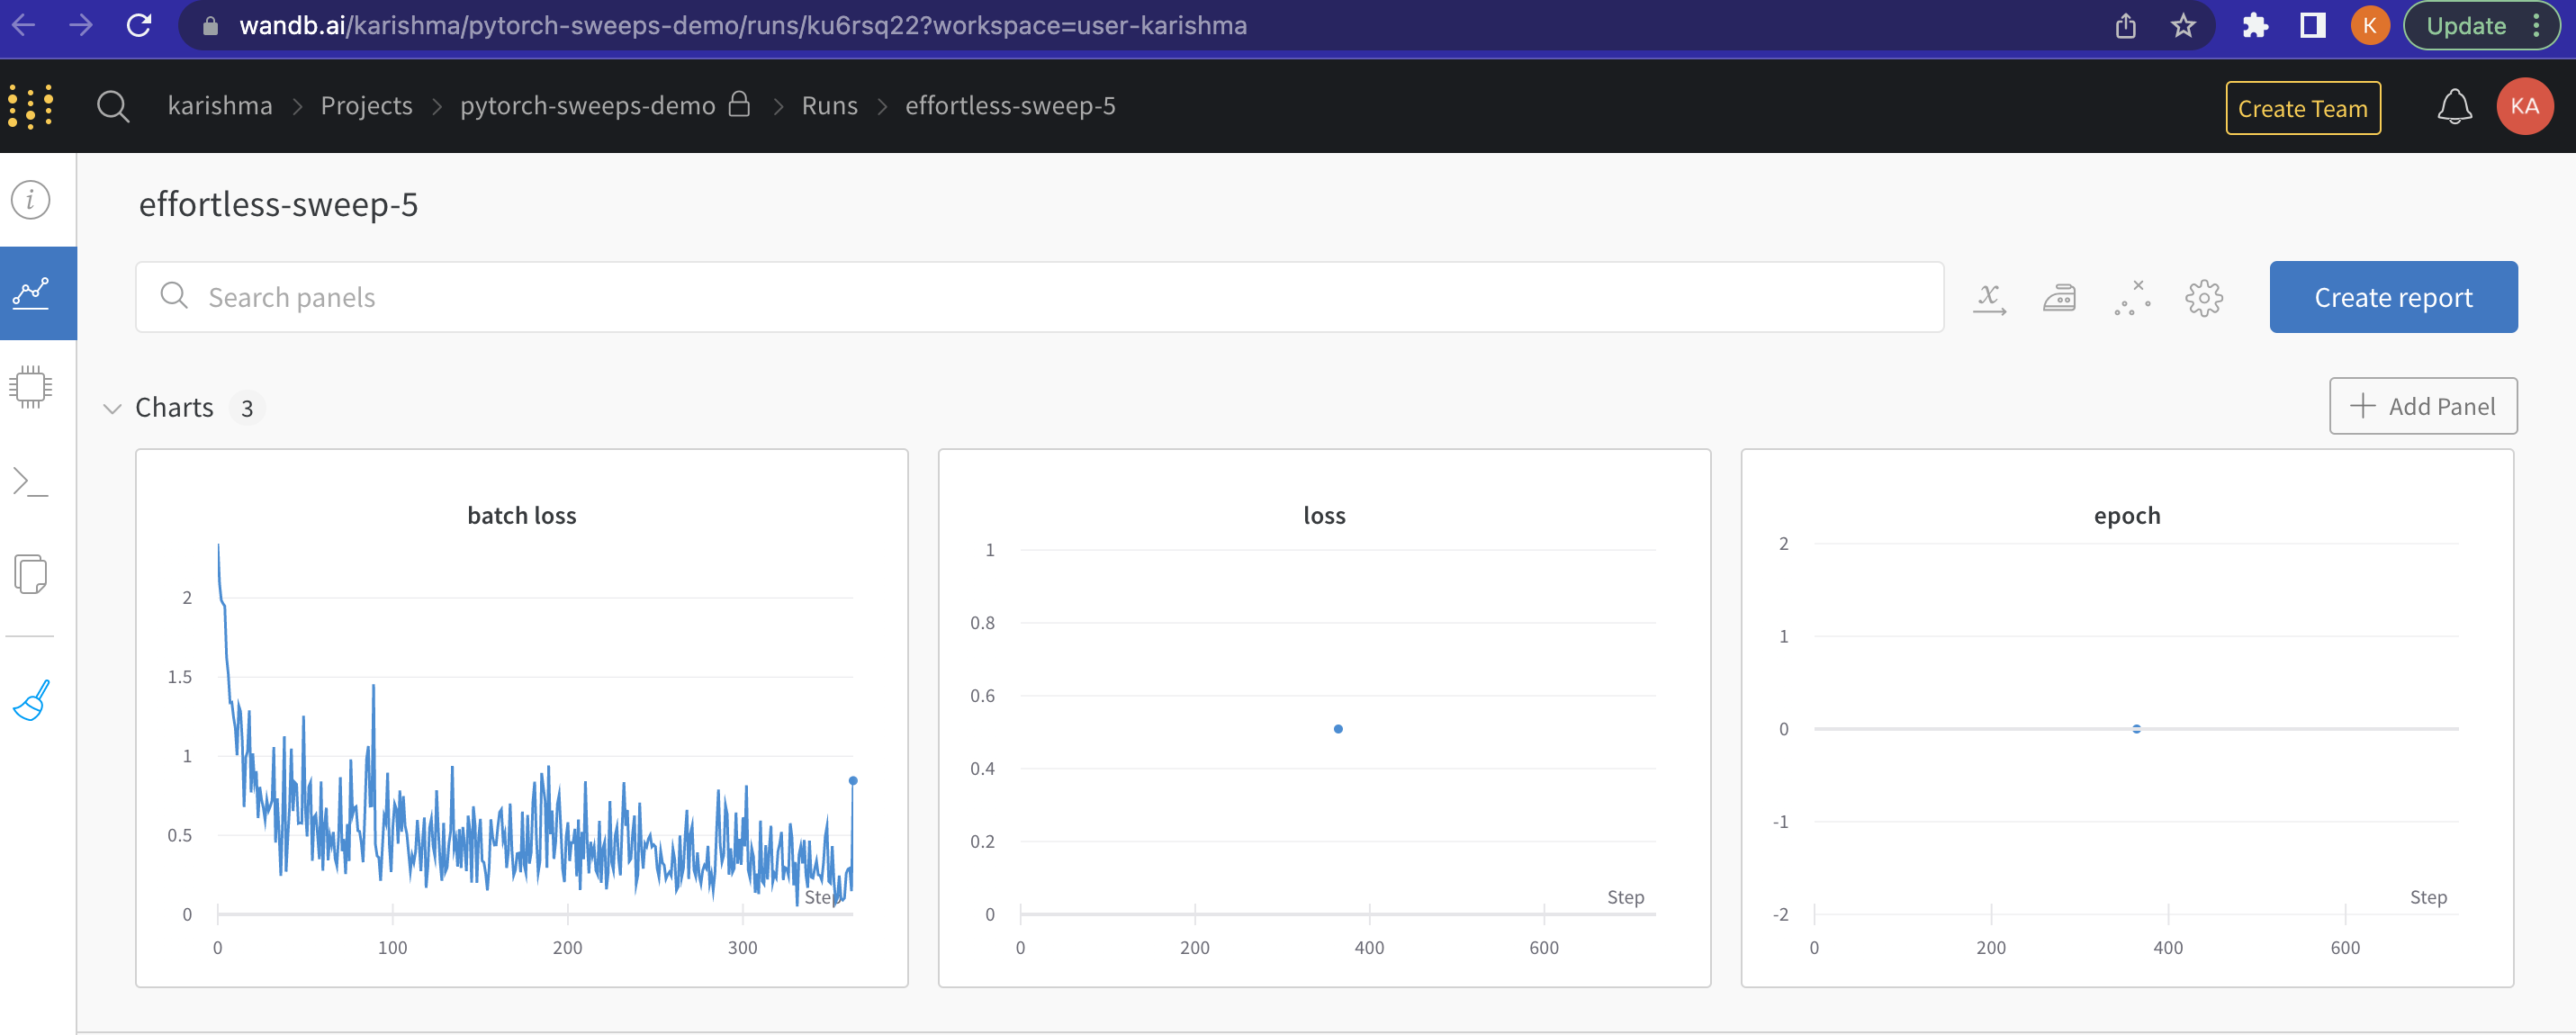
